# 3D CNN

In [ ]:
import time

# wether to use tpu for training or not
USE_TPU = False
TRAIN_MODEL = True
# RANDOM_SEED = 4200
RANDOM_SEED = time.time()
print(RANDOM_SEED)

1606327501.930212


In [ ]:
from google.colab import drive

# drive.mount("/content/gdrive", force_remount=True)
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from google.colab import auth


GCLOUD_PROJECT_ID = 'fiit-dp'
# ./logs and ./checkpints directories must exist in the bucket
GCLOUD_STORAGE_BUCKET = 'fiit-dp-training'


if USE_TPU:
  auth.authenticate_user()

  !gcloud config set project '$GCLOUD_PROJECT_ID'

In [ ]:
if USE_TPU:
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
  !apt -qq update
  !apt -qq install gcsfuse

In [ ]:
if USE_TPU:
  !mkdir 'gcs_bucket'
  !gcsfuse '$GCLOUD_STORAGE_BUCKET' 'gcs_bucket'

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
# Install SimpleITK
!pip install SimpleITK

# Install tf-nightly
# !pip install tf-nightly

     |████████████████████████████████| 44.9MB 124kB/s 


In [ ]:
import tensorflow as tf

tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.0
Num GPUs Available:  1


In [ ]:
import os

saliencies_and_segmentations_v2_path = "/content/gdrive/My Drive/saliencies_and_segmentations_v2"

def get_path_to_saliencies_and_segmentations(sub_path):
  return os.path.join(saliencies_and_segmentations_v2_path, sub_path)

## MRISequence


In [ ]:
import os
import math

import sklearn
import numpy as np
import SimpleITK as sitk

from keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from skimage.transform import resize


def process_image(path, input_shape, resize_img, normalization):
    x = sitk.GetArrayFromImage(sitk.ReadImage(path))
    if resize_img == True:
      x = resize(x, input_shape[:3])
    if normalization is not None:
      x = normalize(x, normalization)
    return np.array(x).reshape(input_shape)

def invert_img(x):
    # [x, y, z, 1]
    return x[:, :, ::-1, :]

def normalize(x, normalization):
    desc = normalization['desc']
    if normalization['type'] != 'standardization':
      return (x - desc['min']) / (desc['max'] - desc['min'])
    return (x - desc['mean']) / desc['std']

def apply_augmentation(x, augmentations, name, force=False):
    if name == 'random_swap_hemispheres':
      p = augmentations['random_swap_hemispheres']
      if force or np.random.uniform(0) < p:
        return invert_img(x), True
    return x, False

def apply_augmentations(x, augmentations):
    if augmentations is None:
      return x

    for augmentation in augmentations.keys():
      x, applied = apply_augmentation(x, augmentations, augmentation)
      if applied:
        return x

    return x

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class MRISequence(Sequence):
    def __init__(self, path, batch_size, input_shape, class_names=['AD', 'CN'], 
                 augmentations=None, augmentations_inplace=True, images=True, one_hot=True, class_weight=None,
                 normalization=None, resize_img=True):
      if one_hot == False:
        self.encoder = LabelEncoder()
        self.encoder.fit(np.array(class_names))
      else:
        self.encoder = OneHotEncoder(sparse=False)
        self.encoder.fit(np.array(class_names).reshape(-1, 1))

      self.class_weight = class_weight
      self.one_hot = one_hot
      self.input_shape = input_shape
      self.resize_img = resize_img
      self.class_names = class_names
      self.images = images
      self.augmentations = augmentations
      self.augmentations_inplace = augmentations_inplace
      self.normalization = normalization

      self.batch_size = batch_size
      self.images_dirs = [os.path.join(path, key) for key in os.listdir(path)]
        
    def __len__(self):
        return math.ceil(len(self.images_dirs) / self.batch_size)
        # Uncomment for debugging (when you need a smaller subset of data and faster training time)
        # return math.ceil(18 / self.batch_size)

    def __getitem__(self, idx):
        images_dirs = self.images_dirs[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if not len(images_dirs):
          batch_y = np.array([]).reshape(-1)
          if self.one_hot:
            batch_y = np.array([]).reshape(-1, len(self.class_names))

          return np.array([]).reshape(-1, *input_shape), batch_y

        batch_y = self.__encode(np.array([self.__readfile(os.path.join(image_dir, 'real_diagnosis.txt')) for image_dir in images_dirs]))

        # if we disabled loading images, don't do it
        if not self.images:
          batch_x = np.array([None for image_dir in images_dirs])
        else:
          batch_x = np.array([process_image(os.path.join(image_dir, 'data.nii'), self.input_shape, self.resize_img, self.normalization) for image_dir in images_dirs])
          
          if self.augmentations:
            if self.augmentations_inplace:
              batch_x = np.array([apply_augmentations(x, self.augmentations) for x in batch_x])
            else:
              new_batch_x = np.array([]).reshape(-1, *input_shape)
              new_batch_y = np.array([]).reshape(-1, len(self.class_names))
              
              for augmentation in self.augmentations.keys():
                aug_batch_x = np.array([x for x, _ in [apply_augmentation(x, augmentations, augmentation, force=True) for x in batch_x]])
                new_batch_x = np.concatenate((new_batch_x, aug_batch_x), axis=0)
                new_batch_y = np.concatenate((new_batch_y, np.copy(batch_y)), axis=0)

              batch_x = np.concatenate((batch_x, new_batch_x), axis=0)
              batch_y = np.concatenate((batch_y, new_batch_y), axis=0)
        
        if self.class_weight is None:
          return batch_x, batch_y

        batch_w = np.array([self.class_weight[y] for y in self.__decode(batch_y)])
        return batch_x, batch_y, batch_w

    def __encode(self, labels):
      if self.one_hot == True:
        labels = labels.reshape(-1, 1)
      return self.encoder.transform(labels)

    def __decode(self, labels):
      if self.one_hot == True:
          return np.argmax(labels, axis=1)
      return labels

    def __readfile(self, file_path):
        fo = open(file_path, "r")
        c = fo.readline()
        fo.close()
        return c

## seq_to_np()

Converts sequence to numpy array. If the sequence exists in storage then load it.


In [ ]:
def seq_to_np(seq, path, name):
  path_x = os.path.join(path, f'{name}_x.npy')
  path_y = os.path.join(path, f'{name}_y.npy')

  if os.path.exists(path_x):
    print(f'loading {path_x}, {path_y}...')

    with open(path_x, 'rb') as f:
      train_x = np.load(f, allow_pickle=True)
    with open(path_y, 'rb') as f:
      train_y = np.load(f, allow_pickle=True)
    
    return train_x.reshape((-1, *seq.input_shape)), train_y.reshape(-1, len(seq.class_names))

  print(f'generating {path_x}, {path_y}...')

  train_x = []
  train_y = []

  for batch_x, batch_y, *r in seq:
    if batch_x is not None and batch_y is not None:
      for x, y in zip(batch_x, batch_y):
          train_x.append(x)
          train_y.append(y)

  with open(path_x, 'wb') as f:
    np.save(f, np.array(train_x))
  with open(path_y, 'wb') as f:
    np.save(f, np.array(train_y))

  return np.array(train_x).reshape((-1, *seq.input_shape)), np.array(train_y).reshape(-1, len(seq.class_names))

## train_test_split()

In [ ]:
import os
import time
import shutil
import numpy as np

from tqdm import tqdm


def train_test_split(src, dst, **kwargs):
  split = kwargs.get('split', (0.8, 0.1, 0.1))
  dirname = kwargs.get('dirname', str(int(time.time())))

  if len(split) != 3:
    raise "split mus be length of three!"

  if sum(split) != 1:
    raise "sum of split must be 1!"

  dst_dir = os.path.join(dst, f'{dirname}')
  train_dir = os.path.join(dst_dir, 'train')
  test_dir = os.path.join(dst_dir, 'test')
  val_dir = os.path.join(dst_dir, 'val')
  
  if os.path.exists(dst_dir):
    print("not copying files since the destination directory already exists")

    return train_dir, test_dir, val_dir

  os.mkdir(dst_dir)
  print(f"copying to {dst_dir}...\n")

  # list of directories to copy
  src_dirs = os.listdir(src)
  print('shuffling an array...')
  np.random.shuffle(src_dirs)

  print('copying files...')
  src_dirs_count = len(src_dirs)
  for idx, dir in tqdm(enumerate(src_dirs), total=src_dirs_count):
    dst_dir = train_dir

    if idx > split[0] * src_dirs_count:
      dst_dir = test_dir
    if idx > (split[0] + split[1]) * src_dirs_count:
      dst_dir = val_dir

    shutil.copytree(os.path.join(src, dir), os.path.join(dst_dir, dir))

  return train_dir, test_dir, val_dir


# train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/')

In [ ]:
import tensorflow as tf

from keras.layers import Lambda


@tf.function
def random_invert_img(x, p):
  if tf.random.uniform([]) < p:
    # [x, y, z, 1]
    return x[:, :, ::-1, :]
  return x

def RandomSwapBrainHemisphere(factor=0.5):
  return Lambda(lambda x: random_invert_img(x, factor))

## MRITensorBoardCallback

In [ ]:
import io
import os
import itertools
import matplotlib.pyplot as plt

from keras.callbacks import Callback


def to_rgb_image(img, pred_label=None, true_label=None, z_index=None, add_batch_dim=True):
  figure = plt.figure(figsize=(4, 4))
  plt.imshow(img.reshape(img.shape[:-1])[z_index], cmap='gray')
  if true_label is not None and pred_label is not None:
    plt.title(f'true = {true_label}, pred = {pred_label}')
  return plot_to_image(figure, add_batch_dim)


def plot_to_image(figure, add_batch_dim=True):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside 
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  if add_batch_dim:
    # Add the batch dimension
    image = tf.expand_dims(image, 0)  
  return image


def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix', fontsize=36)
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = 'white' if cm[i, j] > threshold else 'black'
    plt.text(j, i, labels[i, j], horizontalalignment='center', color=color, fontsize=18)

  plt.tight_layout()
  plt.ylabel('True label', fontsize=18)
  plt.xlabel('Predicted label', fontsize=18)
  return figure


class MRITensorBoardCallback(Callback):
    def __init__(self, seq, model, z_index=56, max_outputs=18, freq=3, log_dir=None, debug=True):
        """
        seq is the sequence from which is the data taken
        model to fit
        z_index is the index in the 3D image which is visualised
        log_dir is the where is output logged
        max_outputs number of images to output
        freq determines how frequently (each freq epoch) to outpu to tensorboard
        """
        super(MRITensorBoardCallback, self).__init__()
        self.model = model
        self.seq = seq
        self.log_dir = log_dir
        self.z_index = z_index
        self.max_outputs = max_outputs
        self.freq = freq
        self.debug = debug

    def __get_z_index(self, img):
      return max(min(img.shape[1], self.z_index), 0)

    def __debug(self, msg):
      if self.debug:
        print(msg)

    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.freq != 0:
        self.__debug('skipping evaluation of predictions to tensorboard')
        return

      self.__debug(f'evaluation of predictions to tensorboard for epoch #{epoch} (no of batches is {len(self.seq)})...')

      images = []
      class_names = self.seq.class_names
      y_pred = np.array([]).reshape(-1, len(class_names))
      y_true = np.array([]).reshape(-1, len(class_names))

      # Get predictions in batches for seq
      for index, batch in enumerate(self.seq):
        x, y, _ = batch
        self.__debug(f'batch #{index}')
        # Get predictions
        pred = self.model.predict(x)

        # Merge with other predictions
        y_true = np.concatenate([y_true, y])
        y_pred = np.concatenate([y_pred, pred])

        # Encode labels
        true_labels = self.seq.encoder.inverse_transform(y)
        pred_labels = self.seq.encoder.inverse_transform(pred)

        # Do not create more images than we output
        if len(images) >= self.max_outputs:
          continue;

        rgb_images = [to_rgb_image(image, pred_label=pred, true_label=true, z_index=self.z_index, add_batch_dim=False) for image, pred, true in zip(x, pred_labels.reshape(-1), true_labels.reshape(-1))]
        for rgb_image in rgb_images:
          images.append(rgb_image)

      # Create a confussion matrix
      cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
                                                                
      # Log the confusion matrix as an image summary.
      figure = plot_confusion_matrix(cm, class_names=class_names)
      cm_image = plot_to_image(figure)

      file_writer_cm = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/confussion-matrix'))
      file_writer_images = tf.summary.create_file_writer(os.path.join(self.log_dir, 'validation/images'))

      with file_writer_images.as_default():
        # Don't forget to reshape.
        images = images[0:self.max_outputs]
        tf.summary.image("Validation Images", images, max_outputs=self.max_outputs, step=epoch)

      # Log the confusion matrix as an image summary.
      with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

## Evaluation

### plot_training_history()

In [ ]:
import os
import tempfile
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_training_history(history):
  metrics = list(filter(lambda metric: 'val_' not in metric, history.history.keys()))
  ncols = 3
  nrows = math.ceil(len(metrics) / ncols)
  plt.figure(figsize=(nrows * 6, nrows * 6 * 1.25))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(ncols, nrows, n + 1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.xlim([0, len(history.epoch)])
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.25, 1])
    else:
      plt.ylim([0,1])

    plt.legend()

### custom_classification_report

In [ ]:
from sklearn.metrics import classification_report, mean_squared_error, mean_squared_log_error, explained_variance_score, f1_score, accuracy_score, recall_score, make_scorer


def custom_classification_report(class_names, y_true, y_pred, **kwargs):
    clf_report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    # Custom print because of incorrect formatting of original function
    for key in clf_report:
        if isinstance(clf_report[key], dict):
            print(f'\033[1m{key}\033[0m')

            for metric in clf_report[key]:
                print(f'{metric}: {clf_report[key][metric]}')
        else:
            print(f'{key}: {clf_report[key]}')

        print('\n')
        
    print(f'\033[1mF1\033[0m')
    for average in ['micro', 'macro']:
        print(f'{average}: {f1_score(y_true, y_pred, average=average)}')

    print('\n')
    # https://en.wikipedia.org/wiki/Precision_and_recall
    # https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    sensitivity_score = make_scorer(recall_score)
    specificity_score = make_scorer(recall_score, pos_label=0)

    print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score
    print(f'sensitivity_score: {recall_score(y_true, y_pred, average="micro")}')
    print(f'specificity_score: {recall_score(y_true, y_pred, average="micro", labels=[0])}')

    print('\n')

In [ ]:
def show_simple_metrics(model, test_seq):
  baseline_results = model.evaluate(test_seq, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(f'{name}: {value}')
  print()

In [ ]:
def show_metrics(model, test_seq):
  y_true = np.array([]).reshape(-1, len(class_names))
  y_pred = np.array([]).reshape(-1, len(class_names))

  for batch in test_seq:
    x, y = batch

    pred = model.predict(x)
    
    y_true = np.concatenate([y_true, y])
    y_pred = np.concatenate([y_pred, pred])


  y_true_labels = test_seq.encoder.transform(test_seq.encoder.inverse_transform(y_true).reshape(-1, 1))
  y_pred_labels = test_seq.encoder.transform(test_seq.encoder.inverse_transform(y_pred).reshape(-1, 1))

  # Plot the confussion matrix
  cm = sklearn.metrics.confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
  plot_confusion_matrix(cm, class_names)

  # Plot the metrics
  custom_classification_report(class_names, y_true_labels, y_pred_labels)

In [ ]:
def show_checkpoint_metrics(model, test_seq, number):
  str_number = str(number)
  str_number = "0" * (4 - len(str_number)) + str_number
  load_checkopint(model, CHECKPOINT_DIRECTORY_LOCAL, model_key, f'cp-{str_number}.ckpt')
  show_metrics(model, test_seq)

## load_checkopint

In [ ]:
def load_checkopint(model, checkpoint_dir, model_key, ckpt_name, options=None):
  CHECKPOINT_PATH=os.path.join(checkpoint_dir, model_key, ckpt_name)
  print(f'loading checkpint from {CHECKPOINT_PATH}...')
  model.load_weights(CHECKPOINT_PATH, options=options)

## RandomSwapBrainHemisphere

In [ ]:
import tensorflow as tf

from tensorflow.python.keras import backend as K


@tf.function
def random_invert_img(x, factor):
  if tf.random.uniform([]) < factor:
    # [x, y, z, 1]
    return x[:, :, ::-1, :]
  return x


class RandomSwapBrainHemisphere(tf.keras.layers.Layer):
  def __init__(self, input_shape, factor=0.5):
      super(RandomSwapBrainHemisphere, self).__init__()
      self.factor = factor
      self.__output_shape = input_shape

  def call(self, inputs, training=True):
    if training is None:
      training = K.learning_phase()

    if not training:
      return inputs

    def flip_image_x(imgx):
      return tf.reshape(tf.reverse(imgx, tf.constant([0])), tf.constant([*self.__output_shape[2:]]))

    def flip_image_z(imgz):
      return tf.map_fn(flip_image_x, imgz)

    def flip_image(img):
        if tf.random.uniform([]) < self.factor:
          return tf.map_fn(flip_image_z, img)
        return img

    return tf.reshape(tf.map_fn(flip_image, inputs), tf.constant([-1, *self.__output_shape]))

## get_description()

In [ ]:
def get_description(norm_seq, max_samples=64):
  train_x = []  

  for index, batch in enumerate(norm_seq):
      batch_x, _ = batch                     
      for x in batch_x:
        train_x.append(x)
      if max_samples is not None and len(train_x) >= max_samples:
        break
  
  return {'mean': np.mean(train_x), 'std': np.std(train_x), 'min': np.min(train_x), 'max': np.max(train_x) }

## create_model()

In [ ]:
def create_model(
                 strategy=None,
                 input_shape=None,
                 log_dir=None,
                 train_seq=None,
                 augmentation=False,
                 class_names=None,
                 output_bias=None,
                 batch_norm=False,
                 is_complex=False,
                 dropout=None,
                 l2_beta=None):
  """
  input_shape is (z, x, y, 1)
  log_dir of the tensorboard logs
  train_seq
  class_names
  output_bias
  batch_normis_complex
  """
  if input_shape is None:
    raise "input_shape should not be none!"

  # In the original paper, they experiment with dropout and L2 regularizers
  # they do not specify, where they put dropout layers, and on which layers they
  # apply what types of regularizations
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape=input_shape, name="input_layer"))

  if augmentation == True:
    # NOT WOEKING ON TPU
    model.add(RandomSwapBrainHemisphere(input_shape))

  # L1, L2
  # In the original paper they use input_shape=(116, 113, 83, 1), however it does not match
  # the proportions of our input shape
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)
  model.add(tf.keras.layers.Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2, input_shape=input_shape))
  
  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)
    model.add(tf.keras.layers.Conv3D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  # L3
  model.add(tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), padding='same'))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  # L4, L5
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)
  model.add(tf.keras.layers.Conv3D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)
      
    model.add(tf.keras.layers.Conv3D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  # L6
  model.add(tf.keras.layers.MaxPool3D(pool_size=(3, 3, 3)))

  # Dropout
  if dropout == True:
    model.add(tf.keras.layers.Dropout(dropout))

  # L7, L8
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)

  model.add(tf.keras.layers.Conv3D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)

    model.add(tf.keras.layers.Conv3D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2))

  if batch_norm == True:
    model.add(tf.keras.layers.BatchNormalization())

  # L9
  model.add(tf.keras.layers.MaxPool3D(pool_size=(4, 4, 4)))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  # Flatten
  model.add(tf.keras.layers.Flatten())

  # L10
  if is_complex:
    l2 = None
    if l2_beta is not None:
      l2 = tf.keras.regularizers.L2(l=l2_beta)
    model.add(tf.keras.layers.Dense(512, kernel_regularizer=l2))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  if batch_norm == True:
      model.add(tf.keras.layers.BatchNormalization())

  # L11
  l2 = None
  if l2_beta is not None:
    l2 = tf.keras.regularizers.L2(l=l2_beta)
  model.add(tf.keras.layers.Dense(256, kernel_regularizer=l2))

  # Dropout
  if dropout is not None:
    model.add(tf.keras.layers.Dropout(dropout))

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  # Output
  model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', bias_initializer=output_bias))

  return model

## compile_model()

In [ ]:
def compile_model(model, learning_rate=0.001, decay_steps=50, decay_rate=0.96, beta_1=0.85, beta_2=0.995):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=beta_1, beta_2=beta_2)
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
    loss = tf.keras.losses.CategoricalCrossentropy()

    # Finally compile the model!
    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=[
              tf.metrics.Recall(),
              tf.metrics.Precision(),
              tf.metrics.AUC(),
              tf.metrics.CategoricalAccuracy()
      ],
    )

    return model, optimizer

## augment()

In [ ]:
from skimage import filters



def augment_invert_img(x):
    return x[:, :, ::-1, :]


def augment_rotate_img(x, angle=15):
    x_rotated = tf.keras.preprocessing.image.random_rotation(
        x.reshape(x.shape[:3]),
        angle,
        row_axis=1,
        col_axis=2,
        channel_axis=0,
        fill_mode='nearest',
        cval=0.0,
        interpolation_order=1
    )
    return x_rotated.reshape((*x_rotated.shape, 1))


def augment_random_zoom(x, zoom=0.1):
    x_zoomed = tf.keras.preprocessing.image.random_zoom(
        x.reshape(x.shape[:3]),
        (1 - zoom, 1 - zoom),
        row_axis=1,
        col_axis=2,
        channel_axis=0,
        fill_mode='nearest',
        cval=0.0,
        interpolation_order=1
    )
    return x_zoomed.reshape((*x_zoomed.shape, 1))


def augment_random_shear(x, angle=90):
  x_shared = tf.keras.preprocessing.image.random_shear(
      x.reshape(x.shape[:3]), angle, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest',
      cval=0.0, interpolation_order=1
  )
  return x_shared.reshape((*x_shared.shape, 1))


def augment_random_gaussian_blur(x, sigma=1):
  x = np.array(x.reshape(x.shape[:3]))
  return filters.gaussian(x, multichannel=True, sigma=sigma).reshape((*x.shape, 1))


def augment(x):
  x = x.numpy()

  if tf.random.uniform([], 0, 1) < 0.5:
    x = augment_invert_img(x)
  
  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_rotate_img(x, angle=2.5)

  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_random_zoom(x, zoom=0.01)

  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_random_shear(x, angle=2.5)

  if tf.random.uniform([], 0, 1) < 0.15:
    x = augment_random_gaussian_blur(x, sigma=0.8)

  return x


def get_class_weight(y):
  return class_weight[np.argmax(y.numpy(), axis=0)]

## train()


In [ ]:
class MyModelCeckpoint(tf.keras.callbacks.Callback):
    def __init__(self, path):
      super(MyModelCeckpoint, self).__init__()
      self.path = path

    def on_batch_end(self, epoch, logs={}):
        path = os.path.join(self.path, f'ckpt-{epoch}')
        print(f'Saving checkpoint to {path}...')
        model.save(path, options=tf.saved_model.SaveOptions(experimental_io_device='/job:localhost'))

In [ ]:
import datetime


def train(model,
          train_seq,
          val_seq,
          tpu=False,
          validation='val',
          epochs=50,
          patience=10,
          model_key=None,
          tensorboard_update_freq='epoch',
          mri_tensorboard_callback=False,
          model_checkpoint_callback=True,
          batch_size=8,
          workers=1):
  """
  Start training the model.
  """
  batch_size = train_seq.batch_size
  input_shape = train_seq.input_shape
  
  if model_key is None:
    model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

  print(f'model key: {model_key}')

  checkpoint_dir = os.path.join(CHECKPOINT_DIRECTORY, model_key)
  log_dir = os.path.join(LOG_DIRECTORY, model_key)

  print(f'checkpoint dir - {checkpoint_dir}')
  print(f'log dir - {log_dir}')

  callbacks = [
      # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping 
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=patience, # Number of epochs with no improvement after which training will be stopped.
          restore_best_weights=True,
      ),
  ]
  
  # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
  callbacks.append(tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
      update_freq=tensorboard_update_freq, # batch frequency number / 'epoch'
      histogram_freq=0,
      profile_batch=0
  )),

  if model_checkpoint_callback is not False:
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt'),          
        monitor='val_loss',
        save_weights_only=True,
        verbose=2,
        save_best_only=model_checkpoint_callback != 'save_best_only'
    )),

  if mri_tensorboard_callback:
    callbacks.append(MRITensorBoardCallback(val_seq, model, z_index=input_shape[0] // 2, freq=1, log_dir=log_dir, debug=False))

    # TODO: the path might be configurable in the future
    train_x, train_y = seq_to_np(train_seq, os.path.join('/content/gdrive/My Drive/data-v2'), 'train')
    val_x, val_y = seq_to_np(val_seq, os.path.join('/content/gdrive/My Drive/data-v2'), 'val')

    if validation == 'val_test':
      test_x, test_y = seq_to_np(test_seq, os.path.join('/content/gdrive/My Drive/data-v2'), 'test')

      val_x = np.concatenate([test_x, val_x], axis=0)
      val_y = np.concatenate([test_y, val_y], axis=0)

    print(f'train: {len(train_x)}, val: {len(val_x)}')

  train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
  if USE_TPU:
    train_dataset = train_dataset.map(lambda x, y: (tf.py_function(func=augment, inp=[x], Tout=tf.float32), y))
  else:
    train_dataset = train_dataset.map(lambda x, y: (augment_invert_img(x) if tf.random.uniform([], 0, 1) > 0.5 else x, y, tf.py_function(func=get_class_weight, inp=[y], Tout=tf.float32)))
  batched_train = train_dataset.batch(batch_size)

  val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
  val_dataset = val_dataset.map(lambda x, y: (x, y, tf.py_function(func=get_class_weight, inp=[y], Tout=tf.float32)))
  batched_val = val_dataset.batch(batch_size)

  # train the model
  # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
  if not tpu:
    print('training on gpu...')
    history = model.fit(
        batched_train,
        validation_data=batched_val,
        # batch_size=tpu_config['batch_size'],
        epochs=epochs,
        # class_weight=class_weight,
        callbacks=callbacks)
  else:
    print('training on tpu...')

    history = model.fit(
        batched_train,
        # train_x,
        # train_y,
        validation_data=validation_data,
        # batch_size=tpu_config['batch_size'],
        epochs=epochs,
        class_weight=class_weight,
        callbacks=callbacks)

  return model, checkpoint_dir, history

## Training

### Setup

In [ ]:
%%time

import datetime


# https://github.com/timzatko/fiit-nsiete/blob/master/src/model.py

DEFAULT_LOCAL_CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'checkpoints')
DEFAULT_LOCAL_BCKP_CHECKPOINT_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'bckp-checkpoints')
DEFAULT_TPU_CHECKPOINT_DIRECTORY = os.path.join('/content/gcs_bucket/', 'checkpoints')

# constants
LOG_DIRECTORY = os.path.join('/content/gdrive/My Drive/', 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_LOCAL_CHECKPOINT_DIRECTORY
LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

if not os.path.exists(CHECKPOINT_DIRECTORY):
  os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
  os.mkdir(LOG_DIRECTORY)

if USE_TPU:
  # GCS BUCKET MUST BE MOUNTED!
  LOG_DIRECTORY = 'gs://fiit-dp-training/logs'
  CHECKPOINT_DIRECTORY = 'gs://fiit-dp-training/checkpoints'
  LOG_DIRECTORY_LOCAL = os.path.join('/content/gcs_bucket/', 'logs')
  CHECKPOINT_DIRECTORY_LOCAL = DEFAULT_TPU_CHECKPOINT_DIRECTORY

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(saliencies_and_segmentations_v2_path, '/content/gdrive/My Drive/', split=(0.8, 0.15, 0.05), dirname='data-v2')

# set the batch size for mri seq
# this does not apply when training with TPU!
batch_size = 12
input_shape = (112, 112, 105, 1)
resize_img=True

# set the batch size for mri seq
# input_shape = (160, 160, 150, 1)
# resize_img=False

if USE_TPU:
  batch_size = 32

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weight = {0: 0.8271604938271606, 1: 1.2641509433962266}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
  print('initializing desc...')
  desc = get_description(MRISequence(
    train_dir,
    64,
    class_names=class_names,
    input_shape=input_shape), max_samples=None)
  print(desc)
  
normalization={'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations={'random_swap_hemispheres': 0.5}

print('initializing train_seq...')
# initialize sequence
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=not USE_TPU,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing val_seq...')
val_seq = MRISequence(
    val_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    class_weight=class_weight,
    normalization=normalization)
print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    one_hot=one_hot,
    normalization=normalization)

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing val_seq...
initializing test_seq...
log_dir: /content/gdrive/My Drive/logs/20201125-180540
CPU times: user 8.03 ms, sys: 522 µs, total: 8.56 ms
Wall time: 4.09 s


In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([243/159, 159/243])

model_config = {
    'input_shape': input_shape,
    'log_dir': log_dir, 
    'train_seq': train_seq,
    'class_names': class_names,
    # 'l2_beta': 0.001,
    'l2_beta': 0.0005,
    # 'l2_beta': None,
    'dropout': 0.10,
    # 'dropout': None,
    'output_bias': initial_bias,
    # 'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': False if USE_TPU else False,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
    # 'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
    # 'beta_1': 0.85,
    'beta_1': 0.90,
    # 'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'tpu': USE_TPU,
    'model_key': model_key,
    'validation': 'val_test',
    'epochs': 150 if USE_TPU else 150,
    'patience': 150,
    'tensorboard_update_freq': 'epoch' if USE_TPU else 'epoch', # since TPU is hell fast, update tensorboard only on epoch end
    'mri_tensorboard_callback': not USE_TPU,
    'model_checkpoint_callback': 'save_best_only',
    # 'model_checkpoint_callback': False,
}

### GPU

In [ ]:
if not USE_TPU:
  model = create_model(**model_config)
  model, *_ = compile_model(model, **compile_config)
  model.build(input_shape=input_shape)
  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 112, 112, 105, 32) 896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 56, 56, 53, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 53, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 56, 56, 53, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 18, 18, 17, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 18, 18, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 4, 4, 128)      0

In [ ]:
if not USE_TPU and not TRAIN_MODEL:
  load_checkopint(model, DEFAULT_LOCAL_BCKP_CHECKPOINT_DIRECTORY, '20201113-091456', 'cp-0063.ckpt')

In [ ]:
%%time

if not USE_TPU and TRAIN_MODEL:
  # tf.executing_eagerly()
  
  
  model, checkpoint_dir, history = train(
      model,
      train_seq,
      val_seq,
      **train_config
  )

model key: 20201125-180540
checkpoint dir - /content/gdrive/My Drive/checkpoints/20201125-180540
log dir - /content/gdrive/My Drive/logs/20201125-180540
loading /content/gdrive/My Drive/data-v2/train_x.npy, /content/gdrive/My Drive/data-v2/train_y.npy...
loading /content/gdrive/My Drive/data-v2/val_x.npy, /content/gdrive/My Drive/data-v2/val_y.npy...
loading /content/gdrive/My Drive/data-v2/test_x.npy, /content/gdrive/My Drive/data-v2/test_y.npy...
train: 402, val: 100
training on gpu...
Epoch 1/150
34/34 [==============================] - ETA: 0s - loss: 0.9999 - recall: 0.5771 - precision: 0.5771 - auc: 0.5734 - categorical_accuracy: 0.5771
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoints/20201125-180540/cp-0001.ckpt
34/34 [==============================] - 90s 3s/step - loss: 0.9999 - recall: 0.5771 - precision: 0.5771 - auc: 0.5734 - categorical_accuracy: 0.5771 - val_loss: 0.9037 - val_recall: 0.6800 - val_precision: 0.6800 - val_auc: 0.6994 - val_categorical_accu

### TPU

In [ ]:
import tensorflow as tf
import os

tf.executing_eagerly()
tf.keras.backend.clear_session()

      
if USE_TPU:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']

  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)

  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)

  print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
# TPU Support
# https://towardsdatascience.com/how-to-colab-with-tpu-98e0b4230d9c

if USE_TPU:
  strategy = tf.distribute.TPUStrategy(cluster_resolver)

  with strategy.scope():
    model = create_model(**model_config)
    model, optimizer = compile_model(model, **compile_config)
    model.build(input_shape=input_shape)
    model.summary()
  
BATCH_SIZE_PER_REPLICA = batch_size # strategy.num_replicas_in_sync
print(f'BATCH_SIZE_PER_REPLICA {BATCH_SIZE_PER_REPLICA}')
print(model_config)
print(compile_config)
print(train_config)

BATCH_SIZE_PER_REPLICA 12
{'input_shape': (112, 112, 105, 1), 'log_dir': '/content/gdrive/My Drive/logs/20201125-180540', 'train_seq': <__main__.MRISequence object at 0x7f0074830ac8>, 'class_names': ['AD', 'CN'], 'l2_beta': 0.0005, 'dropout': 0.1, 'output_bias': array([ 0.42415724, -0.42415724]), 'batch_norm': False, 'is_complex': False}
{'learning_rate': 0.00025, 'decay_steps': 25, 'decay_rate': 0.96, 'beta_1': 0.9, 'beta_2': 0.999}
{'tpu': False, 'model_key': '20201125-180540', 'validation': 'val_test', 'epochs': 150, 'patience': 150, 'tensorboard_update_freq': 'epoch', 'mri_tensorboard_callback': True, 'model_checkpoint_callback': 'save_best_only'}


In [ ]:
if USE_TPU and not TRAIN_MODEL:
  with strategy.scope():
    load_checkopint(model, DEFAULT_TPU_CHECKPOINT_DIRECTORY, '20201110-143615', 'cp-0067.ckpt', tf.train.CheckpointOptions(experimental_io_device="/localhost:job"))  

# with strategy.scope():
#   load_checkopint(model, DEFAULT_LOCAL_BCKP_CHECKPOINT_DIRECTORY, '20201110-143615', 'cp-0067.ckpt', tf.train.CheckpointOptions(experimental_io_device="/localhost:job"))  

In [ ]:
%%time

if USE_TPU and TRAIN_MODEL:
  model, checkpoint_dir, history = train(
      model,
      train_seq,
      val_seq,
      **train_config
  )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


## Evaulation

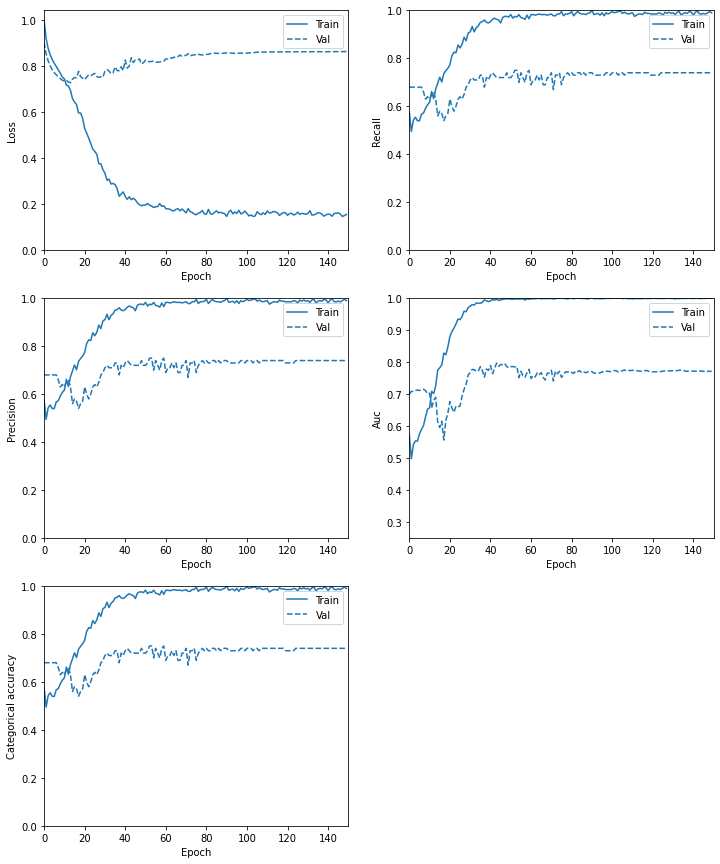

In [ ]:
if TRAIN_MODEL:
  plot_training_history(history)

In [ ]:
%%time

# not working because of sequence
if not USE_TPU:
  show_simple_metrics(model, test_seq)

AD
precision: 0.8333333333333334
recall: 0.7692307692307693
f1-score: 0.8
support: 52


CN
precision: 0.5555555555555556
recall: 0.6521739130434783
f1-score: 0.6
support: 23


micro avg
precision: 0.7333333333333333
recall: 0.7333333333333333
f1-score: 0.7333333333333333
support: 75


macro avg
precision: 0.6944444444444444
recall: 0.7107023411371238
f1-score: 0.7
support: 75


weighted avg
precision: 0.7481481481481482
recall: 0.7333333333333333
f1-score: 0.7386666666666667
support: 75


samples avg
precision: 0.7333333333333333
recall: 0.7333333333333333
f1-score: 0.7333333333333333
support: 75


F1
micro: 0.7333333333333333
macro: 0.7


accuracy_score: 0.7333333333333333
sensitivity_score: 0.7333333333333333
specificity_score: 0.7692307692307693


CPU times: user 16.4 s, sys: 1.03 s, total: 17.4 s
Wall time: 18.7 s


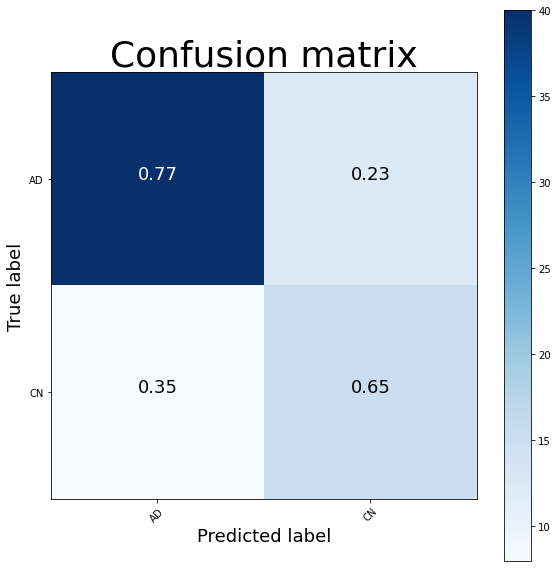

In [41]:
%%time

show_metrics(model, test_seq)

In [40]:
# show_checkpoint_metrics(model, test_seq, 71)